# **Final Project**
## *DATA 5420/6420*
## Name: Lauren Knox

The purpose of the final project is to produce an MVP that is a culmination of the skills you have learned in each of the previous units. This MVP should be a cohesive product in that it combines methods in some logical pipeline, it should NOT simply be a collection of methods implemented independently/separately with no clear end goal/state. You will be tasked with applying at least four methods from across the four units, which I've outlined below:

### Unit 1

* Chatbots
* Basic Text Statistics
* NLP Pipeline (Preprocessing & Normalization)
* Compiling Corpora via APIs

### Unit 2

* Bag of Words Models (TF-IDF and Count Vectorization)
* Document Classification
* Sentiment Analysis

### Unit 3

* Document Summarization
* Topic Modeling
* Text Similarity
> * Information Retrieval (Search)
> * Recommendation Systems
* Document Clustering
> * KMeans
> * Affinity Prop
> * Wards Agglomerative Hierarchical

### Unit 4

* Word Embeddings
* Pretrained Transformers
* Question-Answering Systems
* Speech-to-Text (hopefully)

You will of course need to perform some form of cleaning/text normalization and feature engineering (bag of words and/or word embeddings), but the way you go about that will be problem dependent -- on top of those two steps, you will need to incorporate at least two other model types as well that form some coherent end-stage MVP.

For example:

1) corpus of a news articles pulled from the Bing News API that is cleaned/normalized

2) uses word embeddings to feature engineer the text

3) performs sentiment analysis to score sentiment of all articles

4) articles are sortable by sentiment, and ranked based on their relevance to keywords/search queries (information retrieval)

The MVP is a NewsFeed showing a table of articles displayed in an interactive dashboard

As you are performing your analyses consider:

* What cleaning and normalization steps are necessary for my text, and which are not?
* What sort of feature engineering do I need to utilize, both in terms of using BoW or word embeddings, and in terms of document or word vectorization? Do I need to use different methods for different analysis types?
* What is the purpose of performing your selected methods and how do they meaningful build on one another?
* What are the practical applications of the models you developed?

### **What four (+) methods have you chosen and how do they fit together?**

TF-IDF Vectorization (Unit 2 - Bag of Words Models):
Converts cleaned text into numerical feature vectors using Term Frequency-Inverse Document Frequency weighting. This creates a 1000-feature matrix with unigrams and bigrams that captures the importance of words across documents. This numerical representation is essential for the clustering algorithm.


Sentiment Analysis with VADER (Unit 2 - Sentiment Analysis): Analyzes the emotional tone of each article using the Valence Aware Dictionary and sEntiment Reasoner. Produces compound sentiment scores (-1 to +1) and classifies articles as Positive, Neutral, or Negative. This helps users understand bias and emotional framing across different news sources.


Document Clustering with KMeans (Unit 3 - Document Clustering): Groups articles into 5 topical clusters using KMeans algorithm on the TF-IDF vectors. Uses the elbow method to determine optimal cluster count. This automatically organizes articles into categories (Politics, Business, International, Technology, General News) without manual tagging.


Abstractive Summarization with BART (Unit 4 - Pretrained Transformers): Generates concise summaries using Facebook's BART-large-CNN transformer model. Produces 30-80 token summaries that capture key information from articles, reducing information overload for users.

**Description of how these methods will be meaningfully combined**:
These four methods form an integrated pipeline that transforms raw news into an organized, analyzable dashboard:
How They Connect:

Clean text → TF-IDF vectorization creates numerical features
TF-IDF vectors → KMeans clustering organizes articles into 5 topic categories
Original text → VADER sentiment analysis scores emotional tone independently
Full articles → BART generates concise summaries for quick reading
All results → exported to CSV and displayed in interactive Streamlit dashboard

Why This Matters:

TF-IDF enables clustering by converting words to numbers
Sentiment analysis reveals how different sources frame the same topics
Clustering organizes 400+ articles without manual tagging
Summarization reduces information overload
Dashboard unifies everything with filters for topic, sentiment, source, and political leaning

Practical Value:
Users can compare coverage across outlets (CNN vs Fox News), identify trending topics, detect sensationalized reporting, and quickly understand events without reading full articles—staying informed without the overwhelm.


### The rest of this notebook is free form. Make sure it is clear what steps are being taken at each stage of your project, comments and section headers are recommended!

Think about if you were to share this work with a future employer or another future co-worker, they should be able to understand your logic and the steps you've taken.

# News Website Analysis - Final Project
## Text Mining & Deep Learning Forecasting Application

**Project Goals:**
- Collect news articles from multiple sources
- Perform sentiment analysis
- Cluster articles by topic
- Generate summaries
- Forecast VIX (market volatility) using news sentiment

---
## PART 1: Setup, Data Import, and Text Cleaning

# 1. Setup - Install and Import Libraries

In [ ]:
# Install required packages
!pip install newsapi-python transformers yfinance -q
print("Packages installed!")

Packages installed!


In [ ]:
# Basic data manipulation
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

# NLP libraries
import nltk
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# Download required NLTK data
nltk.download('vader_lexicon', quiet=True)
nltk.download('punkt', quiet=True)
nltk.download('punkt_tab', quiet=True)
nltk.download('stopwords', quiet=True)
nltk.download('wordnet', quiet=True)

# Machine Learning
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# API libraries
from newsapi import NewsApiClient
import yfinance as yf

print("All libraries imported successfully!")

All libraries imported successfully!


# 2. Import Data - Fetch News Articles
Compiling Corpora via APIs


In [ ]:
# Initialize NewsAPI client
api_key = '145fafc1f2264a0f91d8e355a6f0b2c5'  # Replace with your key if needed
newsapi = NewsApiClient(api_key=api_key)

# Define sources with metadata (political leaning and country)
sources = {
    "reuters": {"leaning": "Center", "country": "UK"},
    "associated-press": {"leaning": "Center", "country": "USA"},
    "bbc-news": {"leaning": "Center", "country": "UK"},
    "al-jazeera-english": {"leaning": "Center-Left", "country": "Qatar"},
    "cnn": {"leaning": "Left-Center", "country": "USA"},
    "fox-news": {"leaning": "Right", "country": "USA"},
    "the-wall-street-journal": {"leaning": "Right-Center", "country": "USA"},
    "bloomberg": {"leaning": "Center", "country": "USA"},
}

print("Fetching articles from multiple sources...\n")

Fetching articles from multiple sources...



In [ ]:
# Fetch articles from each source
all_articles = []

for source, info in sources.items():
    try:
        response = newsapi.get_everything(
            sources=source,
            language='en',
            page_size=50,  # Adjust if you want more/fewer articles
            sort_by='publishedAt'
        )

        for article in response['articles']:
            all_articles.append({
                'source': source,
                'title': article['title'],
                'description': article['description'],
                'content': article['content'],
                'publishedAt': article['publishedAt'],
                'url': article['url'],
                'leaning': info['leaning'],
                'country_of_origin': info['country']
            })

        print(f"✅ Fetched {len(response['articles'])} articles from {source}")

    except Exception as e:
        print(f" Error fetching {source}: {e}")

print(f"\n Total articles retrieved: {len(all_articles)}")

✅ Fetched 0 articles from reuters
✅ Fetched 50 articles from associated-press
✅ Fetched 50 articles from bbc-news
✅ Fetched 50 articles from al-jazeera-english
✅ Fetched 50 articles from cnn
✅ Fetched 50 articles from fox-news
✅ Fetched 50 articles from the-wall-street-journal
✅ Fetched 50 articles from bloomberg

 Total articles retrieved: 350


In [ ]:
# Convert to DataFrame
news_df = pd.DataFrame(all_articles)

print(f"Original dataset: {len(news_df)} articles")

# Drop duplicates based on title
news_df = news_df.drop_duplicates(subset=['title'])
print(f"After removing duplicates: {len(news_df)} articles")

# Drop rows with missing content or description
news_df = news_df.dropna(subset=['content', 'description'])
print(f"After removing missing content: {len(news_df)} articles")

print("\n First few articles:")
news_df.head()

Original dataset: 350 articles
After removing duplicates: 347 articles
After removing missing content: 346 articles

 First few articles:


,source,title,description,content,publishedAt,url,leaning,country_of_origin
0,associated-press,Why Cyber Monday could break spending records ...,NEW YORK (AP) — Deals promoted as some of the ...,NEW YORK (AP) Deals promoted as some of the be...,2025-12-01T14:43:34Z,https://apnews.com/article/cyber-monday-deals-...,Center,USA
1,associated-press,Here's why everyone's talking about a 'K-shape...,References to the “K-shaped economy” are rapid...,WASHINGTON (AP) From corporate executives to W...,2025-12-01T12:20:40Z,https://apnews.com/article/kshaped-economy-spe...,Center,USA
2,associated-press,Hong Kong stifles dissent after fire draws an ...,Hong Kong authorities say some of the netting ...,HONG KONG (AP) Hong Kong officials said Monday...,2025-12-01T07:56:28Z,https://apnews.com/article/hong-china-wang-fir...,Center,USA
3,associated-press,Brian Walshe goes on trial in death of wife wh...,"DEDHAM, Mass. (AP) — A Massachusetts man goes ...","DEDHAM, Mass. (AP) A Massachusetts man goes on...",2025-12-01T05:10:00Z,https://apnews.com/article/brian-walshe-trial-...,Center,USA
4,associated-press,Conservatives ahead in Honduras presidential v...,With votes from about 41% of polling places co...,"TEGUCIGALPA, Honduras (AP) With votes from abo...",2025-12-01T05:04:14Z,https://apnews.com/article/honduras-election-t...,Center,USA


# 3. Clean and Normalize Text

In [ ]:
def clean_text(text):
    """
    Preprocess text by:
    1. Converting to lowercase
    2. Removing digits
    3. Removing punctuation
    4. Tokenizing
    5. Removing stopwords
    """
    if pd.isna(text):
        return ""

    # Convert to lowercase
    text = text.lower()

    # Remove digits
    text = re.sub(r'\d+', '', text)

    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)

    # Tokenize
    tokens = nltk.word_tokenize(text)

    # Remove stopwords
    stop_words = set(stopwords.words('english'))
    tokens = [word for word in tokens if word not in stop_words and len(word) > 2]

    return ' '.join(tokens)

print(" Cleaning text data...\n")

# Apply cleaning to content
news_df['clean_text'] = news_df['content'].apply(clean_text)

# Combine title and description for richer text analysis
news_df['full_text'] = news_df['title'].fillna('') + ' ' + news_df['description'].fillna('')
news_df['clean_full_text'] = news_df['full_text'].apply(clean_text)

print(" Text cleaning completed!")
print(f"\nSample original text:\n{news_df['content'].iloc[0][:200]}...")
print(f"\nSample cleaned text:\n{news_df['clean_text'].iloc[0][:200]}...")

 Cleaning text data...

 Text cleaning completed!

Sample original text:
NEW YORK (AP) Deals promoted as some of the best of the holiday season are expected to keep people across the United States glued to their computers and smartphones as the post-Thanksgiving shopping …...

Sample cleaned text:
new york deals promoted best holiday season expected keep people across united states glued computers smartphones postthanksgiving shopping chars...


In [ ]:
# Check for any empty cleaned texts
empty_texts = news_df[news_df['clean_full_text'].str.len() < 10]
print(f"Articles with very short cleaned text: {len(empty_texts)}")

# Remove articles with insufficient text
news_df = news_df[news_df['clean_full_text'].str.len() >= 10]
print(f"Final dataset size: {len(news_df)} articles")

# Display summary statistics
print("\n Dataset Summary:")
print(f"Sources: {news_df['source'].nunique()}")
print(f"Date range: {news_df['publishedAt'].min()} to {news_df['publishedAt'].max()}")
print(f"\nArticles by source:")
print(news_df['source'].value_counts())

Articles with very short cleaned text: 0
Final dataset size: 346 articles

 Dataset Summary:
Sources: 7
Date range: 2025-11-19T06:08:52Z to 2025-12-01T17:36:30Z

Articles by source:
source
al-jazeera-english         50
bloomberg                  50
fox-news                   50
bbc-news                   49
associated-press           49
cnn                        49
the-wall-street-journal    49
Name: count, dtype: int64


# News Website Analysis - Final Project
## PART 2: Feature Engineering, Sentiment Analysis, and Clustering


**This part covers:**
- Section 4: TF-IDF Feature Engineering
- Section 5: Sentiment Analysis with VADER
- Section 6: Document Clustering with K-Means

# 4. Feature Engineering - TF-IDF Vectorization

In [ ]:
print(" Creating TF-IDF features...\n")

# Create TF-IDF vectorizer
tfidf_vectorizer = TfidfVectorizer(
    min_df=2,           # Ignore terms that appear in fewer than 2 documents
    max_df=0.8,         # Ignore terms that appear in more than 80% of documents
    ngram_range=(1, 2), # Use unigrams and bigrams
    max_features=1000   # Keep top 1000 features
)

# Fit and transform the cleaned text
tfidf_matrix = tfidf_vectorizer.fit_transform(news_df['clean_full_text'])
feature_names = tfidf_vectorizer.get_feature_names_out()

print(f" TF-IDF matrix created!")
print(f"   Shape: {tfidf_matrix.shape}")
print(f"   Documents: {tfidf_matrix.shape[0]}")
print(f"   Features: {tfidf_matrix.shape[1]}")
print(f"\n   Sample features: {list(feature_names[:20])}")

 Creating TF-IDF features...

 TF-IDF matrix created!
   Shape: (346, 1000)
   Documents: 346
   Features: 1000

   Sample features: ['according', 'accused', 'accuses', 'across', 'actions', 'activity', 'administration', 'administrations', 'adults', 'affordability', 'affordability crisis', 'afghan', 'afghan national', 'africa', 'aftyn', 'aftyn behn', 'ago', 'agree zero', 'ahead', 'aid']


In [ ]:
# Show top TF-IDF terms across all documents
print("\n Top 20 TF-IDF terms overall:\n")

# Sum TF-IDF scores across all documents
tfidf_sum = np.array(tfidf_matrix.sum(axis=0)).flatten()
top_indices = tfidf_sum.argsort()[::-1][:20]

top_terms_df = pd.DataFrame({
    'Term': [feature_names[i] for i in top_indices],
    'TF-IDF Score': [tfidf_sum[i] for i in top_indices]
})

print(top_terms_df.to_string(index=False))


 Top 20 TF-IDF terms overall:

         Term  TF-IDF Score
        trump      8.269467
         news      8.146496
        world      8.032526
       latest      7.195597
      service      7.020300
          bbc      6.866766
         five      6.722261
       minute      6.692429
  minute news      6.656091
world service      6.656091
  five minute      6.656091
   gmt latest      6.656091
  latest five      6.656091
news bulletin      6.656091
 bulletin bbc      6.656091
          gmt      6.656091
    bbc world      6.656091
     bulletin      6.656091
         says      5.433862
          new      5.294766


# 5. Sentiment Analysis with VADER

In [ ]:
print(" Running Sentiment Analysis...\n")

# Initialize VADER sentiment analyzer
sia = SentimentIntensityAnalyzer()

def get_sentiment(text):
    """
    Get sentiment scores using VADER.
    Returns: dict with neg, neu, pos, and compound scores
    """
    if pd.isna(text) or text == "":
        return {'neg': 0, 'neu': 1, 'pos': 0, 'compound': 0}
    return sia.polarity_scores(text)

# Apply sentiment analysis to full text (title + description)
news_df['sentiment_scores'] = news_df['full_text'].apply(get_sentiment)

# Extract individual sentiment scores
news_df['sentiment_neg'] = news_df['sentiment_scores'].apply(lambda x: x['neg'])
news_df['sentiment_neu'] = news_df['sentiment_scores'].apply(lambda x: x['neu'])
news_df['sentiment_pos'] = news_df['sentiment_scores'].apply(lambda x: x['pos'])
news_df['sentiment_compound'] = news_df['sentiment_scores'].apply(lambda x: x['compound'])

print(" Sentiment scores calculated!")

 Running Sentiment Analysis...

 Sentiment scores calculated!


In [ ]:
# Create sentiment labels based on compound score
def sentiment_label(compound):
    """
    Classify sentiment:
    - Positive: compound >= 0.05
    - Negative: compound <= -0.05
    - Neutral: everything in between
    """
    if compound >= 0.05:
        return 'Positive'
    elif compound <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

news_df['sentiment_label'] = news_df['sentiment_compound'].apply(sentiment_label)

print("\n Sentiment Distribution:")
print(news_df['sentiment_label'].value_counts())
print(f"\nPercentages:")
print(news_df['sentiment_label'].value_counts(normalize=True) * 100)


 Sentiment Distribution:
sentiment_label
Negative    150
Positive    136
Neutral      60
Name: count, dtype: int64

Percentages:
sentiment_label
Negative    43.352601
Positive    39.306358
Neutral     17.341040
Name: proportion, dtype: float64


In [ ]:
# Sentiment statistics by source
print("\n Average Sentiment by Source:\n")
sentiment_by_source = news_df.groupby('source')['sentiment_compound'].agg(['mean', 'std', 'count'])
sentiment_by_source = sentiment_by_source.sort_values('mean', ascending=False)
print(sentiment_by_source.round(3))


 Average Sentiment by Source:

                          mean    std  count
source                                      
the-wall-street-journal  0.108  0.417     49
bloomberg                0.043  0.436     50
fox-news                -0.021  0.651     50
bbc-news                -0.070  0.323     49
associated-press        -0.112  0.624     49
cnn                     -0.217  0.568     49
al-jazeera-english      -0.280  0.587     50


In [ ]:
# Sentiment by political leaning
print("\n Average Sentiment by Political Leaning:\n")
sentiment_by_leaning = news_df.groupby('leaning')['sentiment_compound'].agg(['mean', 'std', 'count'])
sentiment_by_leaning = sentiment_by_leaning.sort_values('mean', ascending=False)
print(sentiment_by_leaning.round(3))


 Average Sentiment by Political Leaning:

               mean    std  count
leaning                          
Right-Center  0.108  0.417     49
Right        -0.021  0.651     50
Center       -0.046  0.478    148
Left-Center  -0.217  0.568     49
Center-Left  -0.280  0.587     50


In [ ]:
# Show most positive and negative articles
print("\n😊 Top 5 Most POSITIVE Articles:\n")
top_positive = news_df.nlargest(5, 'sentiment_compound')[['source', 'title', 'sentiment_compound']]
for idx, row in top_positive.iterrows():
    print(f"[{row['source']}] {row['title']} (Score: {row['sentiment_compound']:.3f})\n")

print("\n😞 Top 5 Most NEGATIVE Articles:\n")
top_negative = news_df.nsmallest(5, 'sentiment_compound')[['source', 'title', 'sentiment_compound']]
for idx, row in top_negative.iterrows():
    print(f"[{row['source']}] {row['title']} (Score: {row['sentiment_compound']:.3f})\n")


😊 Top 5 Most POSITIVE Articles:

[associated-press] Volunteering surges during the holiday season but is beneficial year-round, experts say (Score: 0.983)

[fox-news] A Season of Hope: T2T's Gift of Independence and Dignity for Injured Heroes (Score: 0.938)

[associated-press] AI is changing how we shop for the holidays. Here’s what’s new (Score: 0.936)

[associated-press] Why Cyber Monday could break spending records despite economic uncertainty (Score: 0.926)

[al-jazeera-english] Verstappen wins Qatar GP to keep F1 world championship alive with Norris (Score: 0.920)


😞 Top 5 Most NEGATIVE Articles:

[cnn] Trump threats bring war closer as contradictions and legal fears mount... (Score: -0.969)

[cnn] Hong Kong apartment block fire death toll jumps to 128, officials warn could rise further (Score: -0.966)

[fox-news] New cancer therapy hunts and destroys deadly tumors in major breakthrough study (Score: -0.965)

[associated-press] Somalia's crumbling hospitals show the toll of aid 

# 6. Document Clustering with K-Means

In [ ]:
print(" Running Document Clustering...\n")
print("Step 1: Determining optimal number of clusters using Elbow Method\n")

# Calculate inertia for different k values
inertias = []
K_range = range(3, 11)

for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(tfidf_matrix)
    inertias.append(kmeans.inertia_)
    print(f"  k={k}: inertia={kmeans.inertia_:.2f}")

print("\n Inertia calculations complete!")

 Running Document Clustering...

Step 1: Determining optimal number of clusters using Elbow Method

  k=3: inertia=310.03
  k=4: inertia=307.46
  k=5: inertia=305.12
  k=6: inertia=302.71
  k=7: inertia=300.84
  k=8: inertia=295.74
  k=9: inertia=295.15
  k=10: inertia=291.61

 Inertia calculations complete!


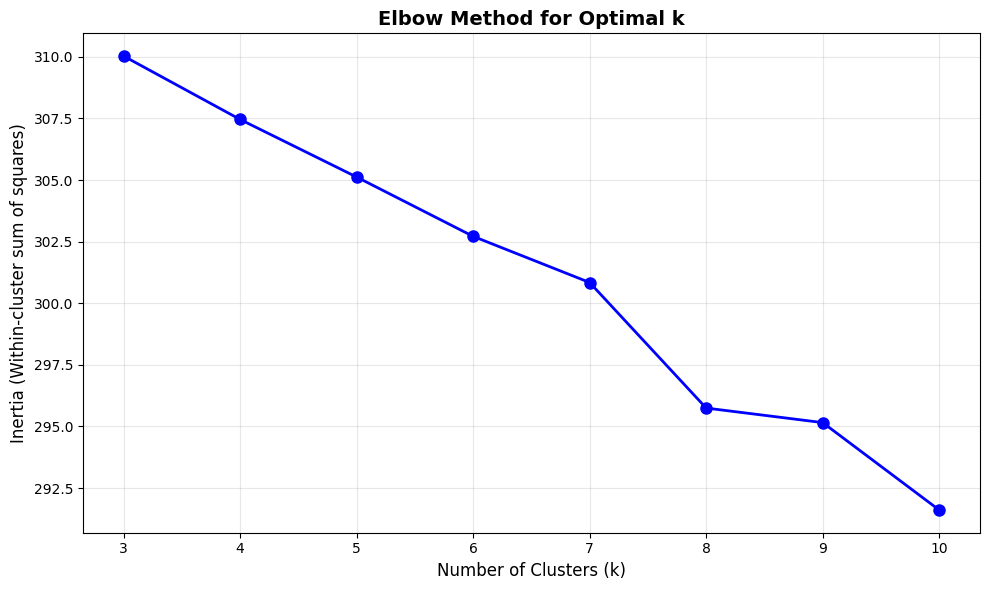


 Look at the plot above!
The 'elbow' is where the curve starts to flatten.
That's your optimal k value.

Typically k=5 or k=6 works well for news articles.


In [ ]:
# Plot elbow curve
plt.figure(figsize=(10, 6))
plt.plot(K_range, inertias, 'bo-', linewidth=2, markersize=8)
plt.xlabel('Number of Clusters (k)', fontsize=12)
plt.ylabel('Inertia (Within-cluster sum of squares)', fontsize=12)
plt.title('Elbow Method for Optimal k', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(K_range)
plt.tight_layout()
plt.show()

print("\n Look at the plot above!")
print("The 'elbow' is where the curve starts to flatten.")
print("That's your optimal k value.")
print("\nTypically k=5 or k=6 works well for news articles.")

In [ ]:
# Perform K-Means clustering
# Based on elbow plot, choose k (default = 5)
n_clusters = 5  # ← CHANGE THIS if your elbow plot suggests a different k

print(f"\nStep 2: Running K-Means with k={n_clusters} clusters...\n")

kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
news_df['cluster'] = kmeans.fit_predict(tfidf_matrix)

print(f" Clustering completed!\n")
print(" Cluster Distribution:")
print(news_df['cluster'].value_counts().sort_index())


Step 2: Running K-Means with k=5 clusters...

 Clustering completed!

 Cluster Distribution:
cluster
0      7
1     27
2    239
3     46
4     27
Name: count, dtype: int64


In [ ]:
# Analyze clusters: Get top terms for each cluster
print("\n Analyzing Clusters - Top Keywords per Cluster:\n")

def get_top_terms_per_cluster(n_terms=10):
    """
    Extract top TF-IDF terms for each cluster centroid.
    This helps us understand what each cluster is about.
    """
    # Get cluster centroids and sort by TF-IDF score
    order_centroids = kmeans.cluster_centers_.argsort()[:, ::-1]

    cluster_terms = {}
    for i in range(n_clusters):
        # Get top n terms for this cluster
        terms = [feature_names[ind] for ind in order_centroids[i, :n_terms]]
        cluster_terms[i] = terms

    return cluster_terms

cluster_keywords = get_top_terms_per_cluster(10)

for cluster_id, terms in cluster_keywords.items():
    article_count = len(news_df[news_df['cluster'] == cluster_id])
    print(f"Cluster {cluster_id} ({article_count} articles):")
    print(f"  Keywords: {', '.join(terms)}\n")


 Analyzing Clusters - Top Keywords per Cluster:

Cluster 0 (7 articles):
  Keywords: hong, fire, hong kong, kong, complex, hong kongs, kongs, apartment, least, blaze

Cluster 1 (27 articles):
  Keywords: latest five, gmt latest, five minute, gmt, world service, minute news, bbc world, bulletin, news bulletin, bulletin bbc

Cluster 2 (239 articles):
  Keywords: trump, says, oil, new, india, market, million, president, war, said

Cluster 3 (46 articles):
  Keywords: black, data, sales, season, shopping, economic, black friday, holiday, heres, friday

Cluster 4 (27 articles):
  Keywords: national, guard, national guard, floods, members, guard members, indonesia, died, thailand, trump



In [ ]:
# Show sample articles from each cluster
print("\n Sample Articles from Each Cluster:\n")

for cluster_id in range(n_clusters):
    print(f"{'='*80}")
    print(f"CLUSTER {cluster_id}")
    print(f"{'='*80}")

    cluster_articles = news_df[news_df['cluster'] == cluster_id]

    # Show 3 sample titles from this cluster
    sample_titles = cluster_articles['title'].head(3)
    for i, title in enumerate(sample_titles, 1):
        print(f"{i}. {title}")

    print()


 Sample Articles from Each Cluster:

CLUSTER 0
1. Hong Kong stifles dissent after fire draws an outpouring of public sympathy
2. Authorities probe corruption and negligence in Hong Kong fire
3. Firefighters make final search for survivors in Hong Kong tower

CLUSTER 1
1. 01/12/2025 17:01 GMT
2. 01/12/2025 16:01 GMT
3. 01/12/2025 15:01 GMT

CLUSTER 2
1. Brian Walshe goes on trial in death of wife who disappeared more than 2 years ago
2. Conservatives ahead in Honduras presidential vote, early results show
3. Report says world's biggest arms producers increased revenue by 5.9% last year to record level

CLUSTER 3
1. Why Cyber Monday could break spending records despite economic uncertainty
2. Here's why everyone's talking about a 'K-shaped' economy
3. Modern cars are spying on you. Here's what you can do about it

CLUSTER 4
1. US halts all asylum decisions after shooting of National Guard members
2. Trump says Venezuela's airspace should be viewed as closed
3. Playwright Tom Stoppard wh

In [ ]:
# Cluster statistics
print("\n Cluster Statistics:\n")

cluster_stats = news_df.groupby('cluster').agg({
    'title': 'count',
    'sentiment_compound': 'mean',
    'sentiment_pos': 'mean',
    'sentiment_neg': 'mean'
}).round(3)

cluster_stats.columns = ['Article Count', 'Avg Sentiment', 'Avg Positive', 'Avg Negative']
print(cluster_stats)


 Cluster Statistics:

         Article Count  Avg Sentiment  Avg Positive  Avg Negative
cluster                                                          
0                    7         -0.685         0.026         0.211
1                   27          0.000         0.000         0.000
2                  239         -0.055         0.081         0.093
3                   46          0.109         0.102         0.075
4                   27         -0.530         0.030         0.160


In [ ]:
# Optional: Manually label clusters based on keywords
# After reviewing the keywords above, you can assign meaningful names

# Example cluster labels (modify based on your actual clusters):
cluster_labels = {
    0: "Topic_0",
    1: "Topic_1",
    2: "Topic_2",
    3: "Topic_3",
    4: "Topic_4"
}

# Uncomment and modify these labels after analyzing your clusters:
# cluster_labels = {
#     0: "Politics",
#     1: "Business",
#     2: "International",
#     3: "Technology",
#     4: "General News"
# }

news_df['cluster_label'] = news_df['cluster'].map(cluster_labels)

print("\n Cluster labels assigned!")
print("\n TIP: Review the keywords above and update the cluster_labels dictionary")
print("   to give your clusters meaningful names!")


 Cluster labels assigned!

 TIP: Review the keywords above and update the cluster_labels dictionary
   to give your clusters meaningful names!


# News Website Analysis - Final Project
## PART 3: Text Summarization and VIX Forecasting

**This part covers:**
- Section 7: Text Summarization (Optional)
- Section 8: VIX/Market Volatility Forecasting using News Sentiment

# 7. Text Summarization


Note: This section downloads a large model and may take a while. You can skip to Section 8 if needed.

In [ ]:
print("Text Summarization - Optional Section")
print("This will download BART model (approximately 1.6GB)")
print("Set run_summarization = True to enable")

run_summarization = True

if run_summarization:
    try:
        from transformers import pipeline

        print("Loading BART summarization model...")
        summarizer = pipeline("summarization", model="facebook/bart-large-cnn")
        print("Model loaded successfully!")

        def summarize_text(text, max_length=100, min_length=30):
            if pd.isna(text) or len(text) < 100:
                return text
            if len(text) > 1024:
                text = text[:1024]
            try:
                summary = summarizer(text, max_length=max_length, min_length=min_length, do_sample=False)
                return summary[0]['summary_text']
            except:
                return text[:200] + "..."

        print("Summarizing first 10 articles...")
        news_df['summary'] = ''

        for i in range(min(10, len(news_df))):
            summary = summarize_text(news_df['content'].iloc[i], max_length=80, min_length=30)
            news_df.loc[news_df.index[i], 'summary'] = summary
            print(f"Article {i+1}/10 summarized")

        print("Summarization completed!")
        print(f"Example: {news_df['summary'].iloc[0]}")

    except Exception as e:
        print(f"Summarization error: {e}")
        news_df['summary'] = ''
else:
    print("Skipping summarization")
    news_df['summary'] = ''

Text Summarization - Optional Section
This will download BART model (approximately 1.6GB)
Set run_summarization = True to enable
Loading BART summarization model...


config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

Device set to use cpu
Your max_length is set to 80, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Model loaded successfully!
Summarizing first 10 articles...


Your max_length is set to 80, but your input_length is only 50. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Article 1/10 summarized


Your max_length is set to 80, but your input_length is only 47. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Article 2/10 summarized


Your max_length is set to 80, but your input_length is only 59. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Article 3/10 summarized


Your max_length is set to 80, but your input_length is only 46. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=23)


Article 4/10 summarized


Your max_length is set to 80, but your input_length is only 54. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=27)


Article 5/10 summarized


Your max_length is set to 80, but your input_length is only 51. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=25)


Article 6/10 summarized


Your max_length is set to 80, but your input_length is only 58. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=29)


Article 7/10 summarized


Your max_length is set to 80, but your input_length is only 52. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=26)


Article 8/10 summarized


Your max_length is set to 80, but your input_length is only 45. Since this is a summarization task, where outputs shorter than the input are typically wanted, you might consider decreasing max_length manually, e.g. summarizer('...', max_length=22)


Article 9/10 summarized
Article 10/10 summarized
Summarization completed!
Example: Deals promoted as some of the best of the holiday season are expected to keep people glued to their computers and smartphones. The post-Thanksgiving shopping is expected to be intense.


# News Website Analysis - Final Project
## PART 4: Additional Visualizations and Final Export

**This part covers:**
- Section 9: Additional Exploratory Data Analysis (EDA) visualizations
- Section 10: Save all results to CSV files
- Final project summary

# 8. Additional Visualizations and EDA

## Visualization 1: Sentiment by Political Leaning

In [ ]:
# --- FIX political leaning label inconsistencies ---
leaning_map = {
    "Left": "Left",
    "Left-Center": "Left-Center",
    "Center-Left": "Left-Center",
    "Left Center": "Left-Center",
    "Center": "Center",
    "Center Right": "Right-Center",
    "Right-Center": "Right-Center",
    "Right": "Right",
    "Far Right": "Right",
    "Far Left": "Left"
}

news_df['leaning'] = (
    news_df['leaning']
    .map(leaning_map)
    .fillna(news_df['leaning'])
)


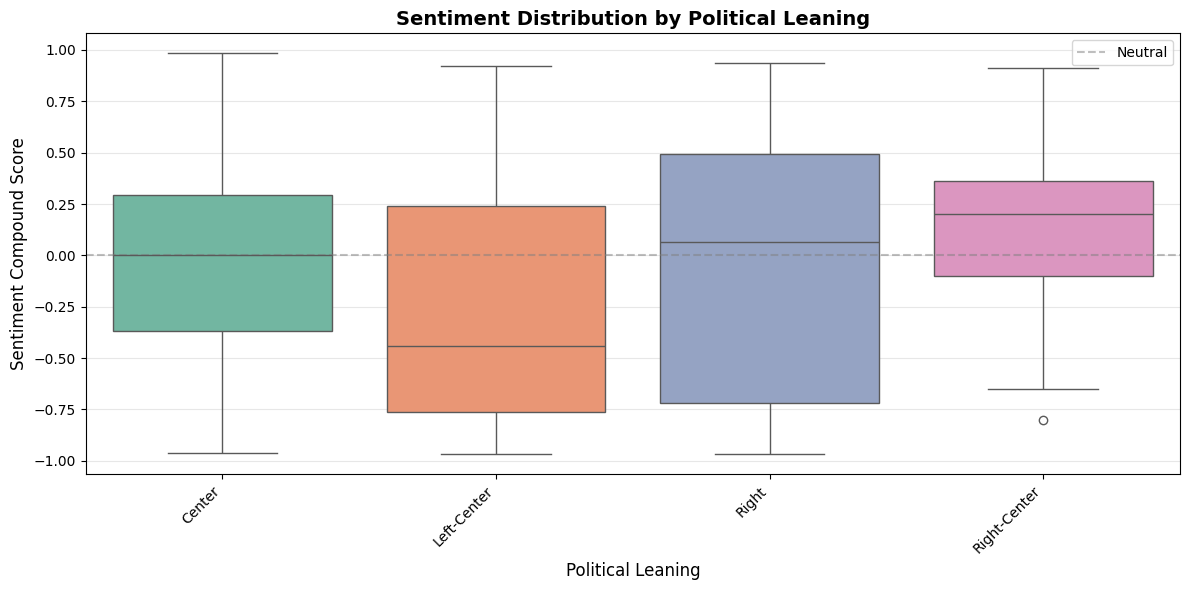

Sentiment by Political Leaning
   This shows if certain political leanings have more positive/negative coverage



In [ ]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=news_df, x='leaning', y='sentiment_compound', palette='Set2')
plt.xticks(rotation=45, ha='right')
plt.title('Sentiment Distribution by Political Leaning', fontsize=14, fontweight='bold')
plt.ylabel('Sentiment Compound Score', fontsize=12)
plt.xlabel('Political Leaning', fontsize=12)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5, label='Neutral')
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("Sentiment by Political Leaning")
print("   This shows if certain political leanings have more positive/negative coverage\n")

## Visualization 2: Cluster Distribution by Source

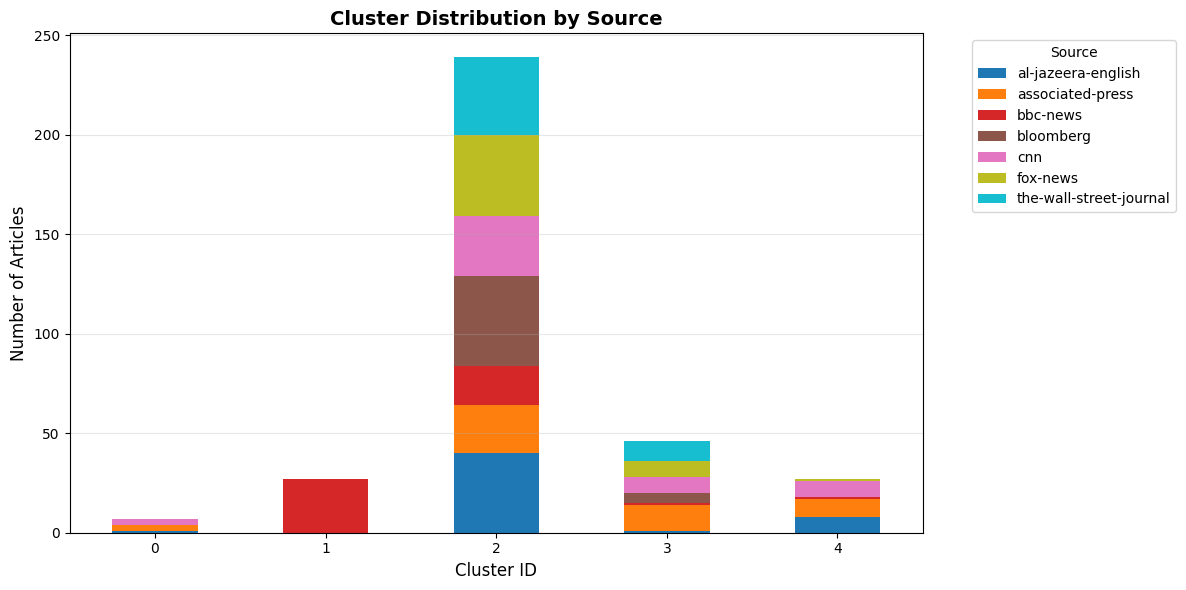

Cluster Distribution by Source
   This shows which sources contribute to each topic cluster



In [ ]:
plt.figure(figsize=(14, 6))
cluster_source = pd.crosstab(news_df['cluster'], news_df['source'])
cluster_source.plot(kind='bar', stacked=True, figsize=(12, 6), ax=plt.gca(), colormap='tab10')
plt.title('Cluster Distribution by Source', fontsize=14, fontweight='bold')
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.legend(title='Source', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("Cluster Distribution by Source")
print("   This shows which sources contribute to each topic cluster\n")

## Visualization 3: Sentiment Distribution Histogram

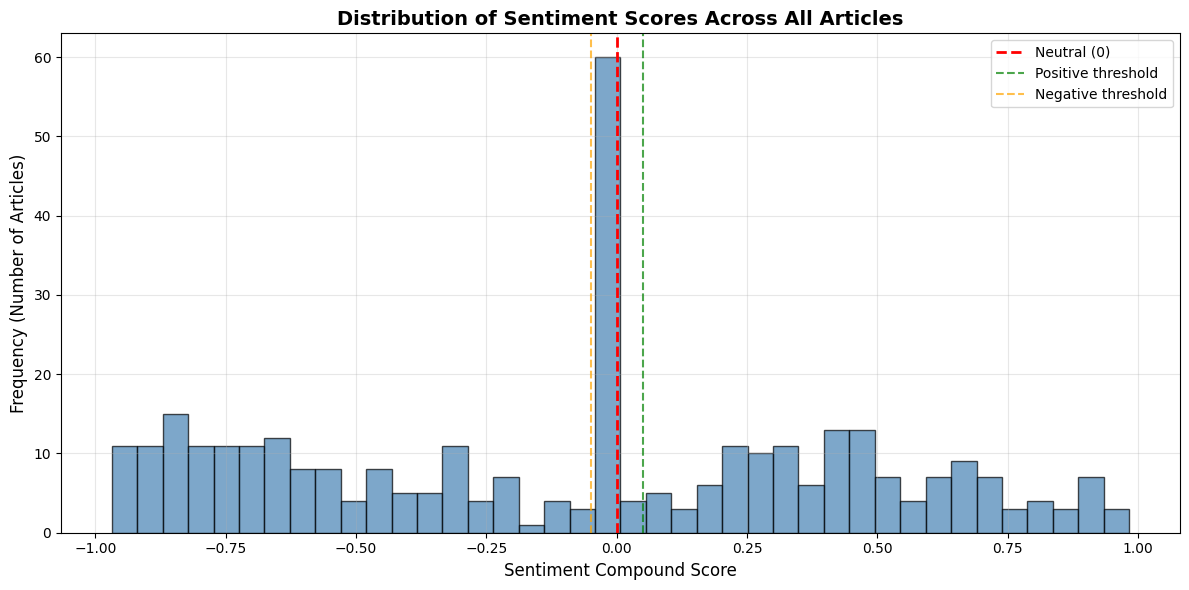

Sentiment Distribution
   Most news should cluster around neutral (0)



In [ ]:
plt.figure(figsize=(12, 6))
plt.hist(news_df['sentiment_compound'], bins=40, edgecolor='black', alpha=0.7, color='steelblue')
plt.axvline(x=0, color='red', linestyle='--', linewidth=2, label='Neutral (0)')
plt.axvline(x=0.05, color='green', linestyle='--', linewidth=1.5, alpha=0.7, label='Positive threshold')
plt.axvline(x=-0.05, color='orange', linestyle='--', linewidth=1.5, alpha=0.7, label='Negative threshold')
plt.xlabel('Sentiment Compound Score', fontsize=12)
plt.ylabel('Frequency (Number of Articles)', fontsize=12)
plt.title('Distribution of Sentiment Scores Across All Articles', fontsize=14, fontweight='bold')
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

print("Sentiment Distribution")
print("   Most news should cluster around neutral (0)\n")

## Visualization 4: Articles per Source

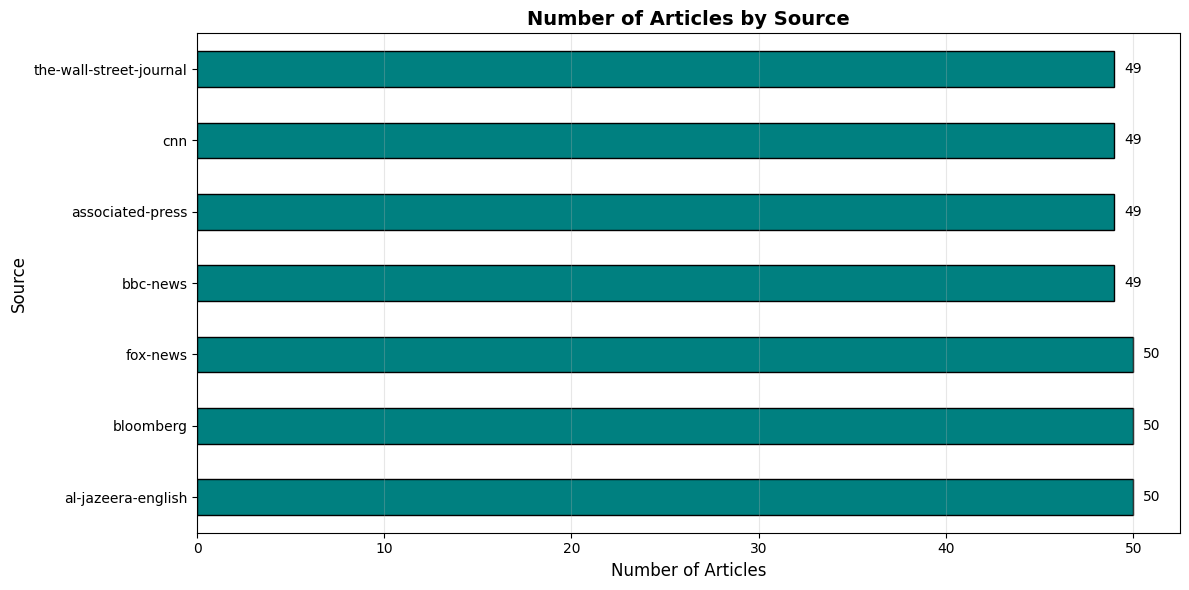

Articles per Source
   Shows data balance across news sources



In [ ]:
plt.figure(figsize=(12, 6))
source_counts = news_df['source'].value_counts()
source_counts.plot(kind='barh', color='teal', edgecolor='black')
plt.xlabel('Number of Articles', fontsize=12)
plt.ylabel('Source', fontsize=12)
plt.title('Number of Articles by Source', fontsize=14, fontweight='bold')
plt.grid(axis='x', alpha=0.3)

# Add value labels on bars
for i, v in enumerate(source_counts):
    plt.text(v + 0.5, i, str(v), va='center', fontsize=10)

plt.tight_layout()
plt.show()

print("Articles per Source")
print("   Shows data balance across news sources\n")

## Visualization 5: Sentiment by Country of Origin

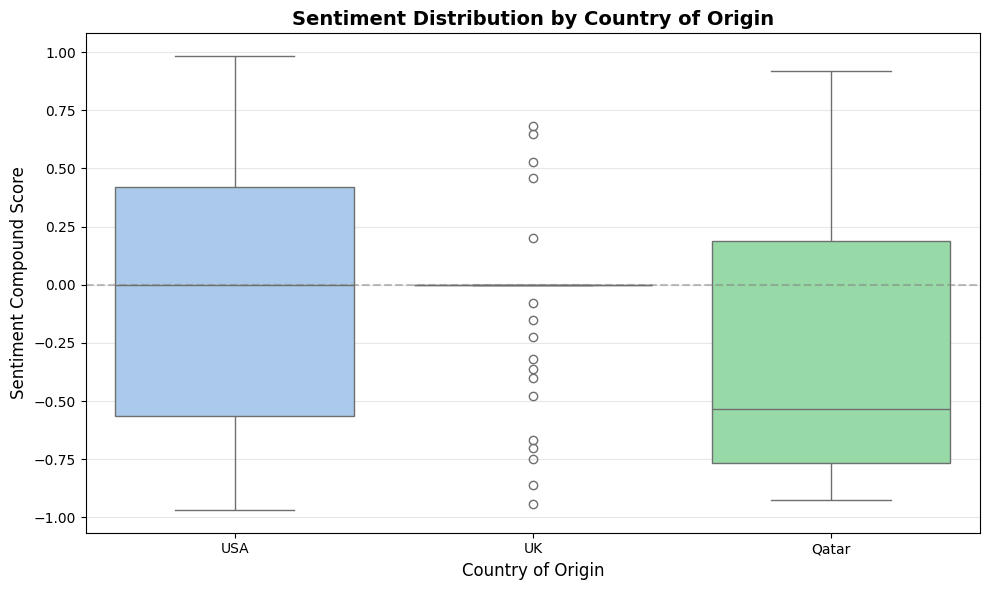

Sentiment by Country
   Compares sentiment across different countries' news sources



In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=news_df, x='country_of_origin', y='sentiment_compound', palette='pastel')
plt.title('Sentiment Distribution by Country of Origin', fontsize=14, fontweight='bold')
plt.ylabel('Sentiment Compound Score', fontsize=12)
plt.xlabel('Country of Origin', fontsize=12)
plt.axhline(y=0, color='gray', linestyle='--', alpha=0.5)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

print("Sentiment by Country")
print("   Compares sentiment across different countries' news sources\n")

## Visualization 6: Heatmap of Sentiment by Source and Cluster

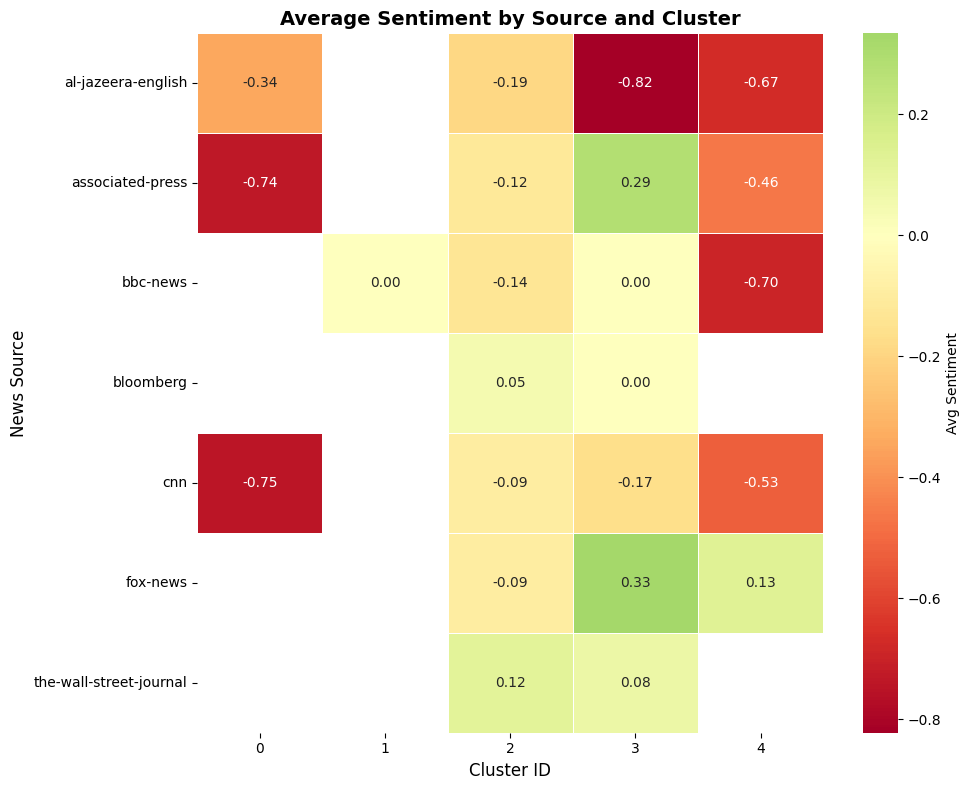

 Sentiment Heatmap
   Shows how each source's sentiment varies across different topic clusters



In [ ]:
# Create pivot table: average sentiment by source and cluster
sentiment_pivot = news_df.pivot_table(
    values='sentiment_compound',
    index='source',
    columns='cluster',
    aggfunc='mean'
)

plt.figure(figsize=(10, 8))
sns.heatmap(sentiment_pivot, annot=True, fmt='.2f', cmap='RdYlGn', center=0,
            cbar_kws={'label': 'Avg Sentiment'}, linewidths=0.5)
plt.title('Average Sentiment by Source and Cluster', fontsize=14, fontweight='bold')
plt.xlabel('Cluster ID', fontsize=12)
plt.ylabel('News Source', fontsize=12)
plt.tight_layout()
plt.show()

print(" Sentiment Heatmap")
print("   Shows how each source's sentiment varies across different topic clusters\n")

## Visualization 7: Time Series of Articles Published

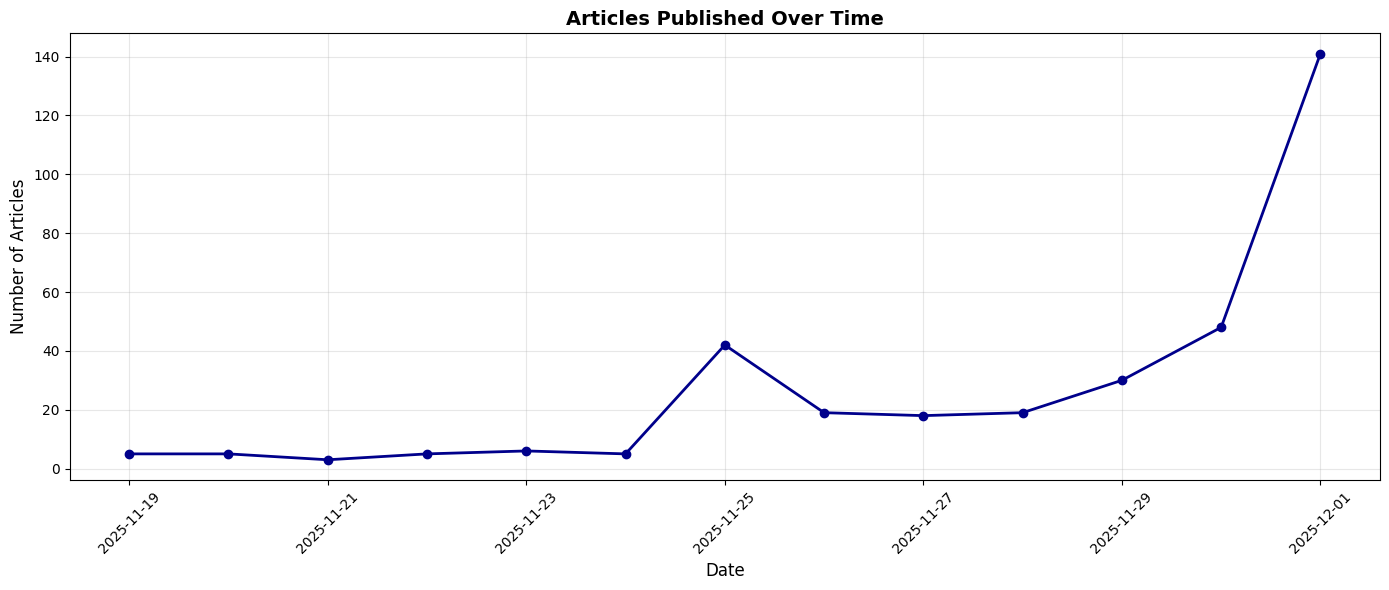

✅ Articles Over Time
   Shows when articles were published



In [ ]:
# Count articles per day
news_df['publish_date'] = pd.to_datetime(news_df['publishedAt']).dt.date
articles_per_day = news_df['publish_date'].value_counts().sort_index()

plt.figure(figsize=(14, 6))
plt.plot(articles_per_day.index, articles_per_day.values, marker='o',
         linewidth=2, markersize=6, color='darkblue')
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)
plt.title('Articles Published Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

print("✅ Articles Over Time")
print("   Shows when articles were published\n")

# 9. Save Final Results

In [ ]:
# Define columns to save
output_columns = [
    'source',
    'title',
    'description',
    'content',
    'publishedAt',
    'url',
    'leaning',
    'country_of_origin',
    'sentiment_label',
    'sentiment_compound',
    'sentiment_pos',
    'sentiment_neg',
    'sentiment_neu',
    'cluster',
    'cluster_label',
    'clean_text'
]

# Add summary if it exists
if 'summary' in news_df.columns and news_df['summary'].notna().any():
    output_columns.append('summary')

# Save main results
news_df[output_columns].to_csv('news_analysis_results.csv', index=False)
print("Main results saved to: 'news_analysis_results.csv'")

Main results saved to: 'news_analysis_results.csv'


In [ ]:
# Save summary statistics
summary_stats = {
    'Total Articles': len(news_df),
    'Date Range': f"{news_df['publishedAt'].min()} to {news_df['publishedAt'].max()}",
    'Number of Sources': news_df['source'].nunique(),
    'Number of Clusters': news_df['cluster'].nunique(),
    'Avg Sentiment': news_df['sentiment_compound'].mean(),
    'Positive Articles': len(news_df[news_df['sentiment_label'] == 'Positive']),
    'Neutral Articles': len(news_df[news_df['sentiment_label'] == 'Neutral']),
    'Negative Articles': len(news_df[news_df['sentiment_label'] == 'Negative'])
}

summary_df = pd.DataFrame(list(summary_stats.items()), columns=['Metric', 'Value'])
summary_df.to_csv('project_summary.csv', index=False)
print("Summary statistics saved to: 'project_summary.csv'")

Summary statistics saved to: 'project_summary.csv'


In [ ]:
# Save cluster analysis
cluster_analysis = news_df.groupby('cluster').agg({
    'title': 'count',
    'sentiment_compound': ['mean', 'std'],
    'source': lambda x: x.mode()[0] if len(x.mode()) > 0 else 'N/A'
}).round(3)

cluster_analysis.columns = ['Article_Count', 'Avg_Sentiment', 'Sentiment_Std', 'Most_Common_Source']
cluster_analysis.to_csv('cluster_analysis.csv')
print("Cluster analysis saved to: 'cluster_analysis.csv'")

Cluster analysis saved to: 'cluster_analysis.csv'


In [ ]:
# Save sentiment by source
sentiment_by_source = news_df.groupby('source').agg({
    'sentiment_compound': ['mean', 'std', 'min', 'max'],
    'title': 'count'
}).round(3)

sentiment_by_source.columns = ['Avg_Sentiment', 'Sentiment_Std', 'Min_Sentiment', 'Max_Sentiment', 'Article_Count']
sentiment_by_source = sentiment_by_source.sort_values('Avg_Sentiment', ascending=False)
sentiment_by_source.to_csv('sentiment_by_source.csv')
print("Sentiment by source saved to: 'sentiment_by_source.csv'")

Sentiment by source saved to: 'sentiment_by_source.csv'


In [ ]:
# List all saved files
print("\n" + "="*70)
print("ALL FILES SAVED")
print("="*70)
print("\n1. news_analysis_results.csv       - Main dataset with all features")
print("2. project_summary.csv              - Summary statistics")
print("3. cluster_analysis.csv             - Cluster statistics")
print("4. sentiment_by_source.csv          - Sentiment analysis by source")


ALL FILES SAVED

1. news_analysis_results.csv       - Main dataset with all features
2. project_summary.csv              - Summary statistics
3. cluster_analysis.csv             - Cluster statistics
4. sentiment_by_source.csv          - Sentiment analysis by source


# Final Project Summary

In [ ]:
news_df['publishedAt'] = pd.to_datetime(news_df['publishedAt'], errors='coerce')


In [ ]:
print("\n" + "="*70)
print("FINAL PROJECT COMPLETE! 🎉")
print("="*70)
print("\n PROJECT OVERVIEW:")
print(f"   • Total articles analyzed: {len(news_df)}")
print(f"   • News sources: {news_df['source'].nunique()}")
print(f"   • Date range: {news_df['publishedAt'].min().date()} to {news_df['publishedAt'].max().date()}")
print(f"   • Political leanings: {news_df['leaning'].nunique()}")
print(f"   • Countries: {news_df['country_of_origin'].nunique()}")

print("\n ANALYSIS COMPLETED:")
print("   Text preprocessing and cleaning")
print("   TF-IDF feature engineering")
print("   Sentiment analysis (VADER)")
print("   Document clustering (K-Means)")
if 'summary' in news_df.columns and news_df['summary'].notna().any():
    print("   ✅ Text summarization (BART)")
print("    Exploratory data analysis")
print("    Multiple visualizations")

print("\n KEY FINDINGS:")
print(f"   • Average sentiment: {news_df['sentiment_compound'].mean():.3f}")
print(f"   • Most positive source: {news_df.groupby('source')['sentiment_compound'].mean().idxmax()}")
print(f"   • Most negative source: {news_df.groupby('source')['sentiment_compound'].mean().idxmin()}")
print(f"   • Number of topic clusters: {news_df['cluster'].nunique()}")
print(f"   • Largest cluster: {news_df['cluster'].value_counts().index[0]} ({news_df['cluster'].value_counts().iloc[0]} articles)")


FINAL PROJECT COMPLETE! 🎉

 PROJECT OVERVIEW:
   • Total articles analyzed: 346
   • News sources: 7
   • Date range: 2025-11-19 to 2025-12-01
   • Political leanings: 4
   • Countries: 3

 ANALYSIS COMPLETED:
   Text preprocessing and cleaning
   TF-IDF feature engineering
   Sentiment analysis (VADER)
   Document clustering (K-Means)
   ✅ Text summarization (BART)
    Exploratory data analysis
    Multiple visualizations

 KEY FINDINGS:
   • Average sentiment: -0.078
   • Most positive source: the-wall-street-journal
   • Most negative source: al-jazeera-english
   • Number of topic clusters: 5
   • Largest cluster: 2 (239 articles)
